# The ARIMA and Seasonal ARIMA Model

## Autoregressive Integrated Moving Averages

The general process for ARIMA models is the following:
* Visualize the Time Series Data
* Make the time series data stationary
* Plot the Correlation and AutoCorrelation Charts
* Construct the ARIMA Model
* Use the model to make predictions


### Setting up the data

In [268]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [269]:
df = pd.read_csv('monthly-milk-production-pounds-p.csv')
df.head()

,Month,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


We better work out the index and parsing along with renaming the column name.

In [270]:
df.set_index('Month', inplace= True)

In [271]:
df.dropna(inplace= True)
df.index = pd.to_datetime(df.index)

In [272]:
df.columns = ['Milk in pounds per cow']

In [273]:
df.head()

,Milk in pounds per cow
Month,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0


In [274]:
df.describe()

,Milk in pounds per cow
count,168.000000
mean,754.708333
std,102.204524
min,553.000000
25%,677.750000
50%,761.000000
75%,824.500000
max,969.000000


In [275]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 to 1975-12-01
Data columns (total 1 columns):
Milk in pounds per cow    168 non-null float64
dtypes: float64(1)
memory usage: 2.6 KB


### Visualizing the data

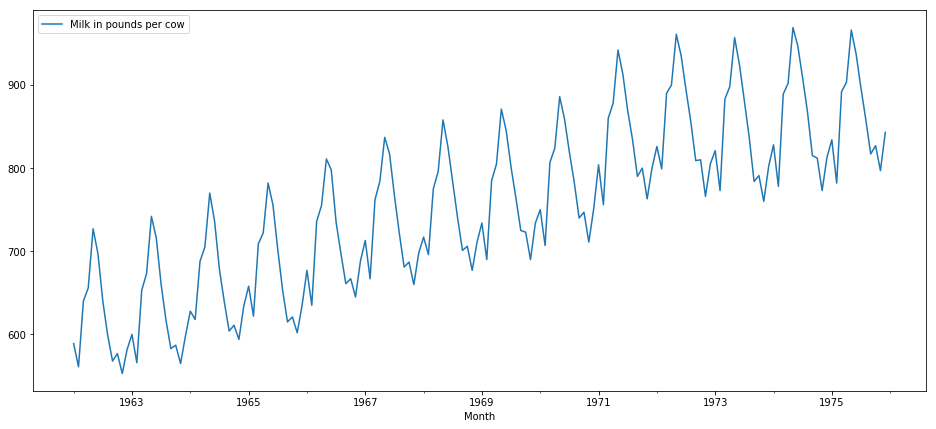

In [276]:
df.plot(figsize=(16,7));

Now we plot out the rolling mean and rolling standard deviations.

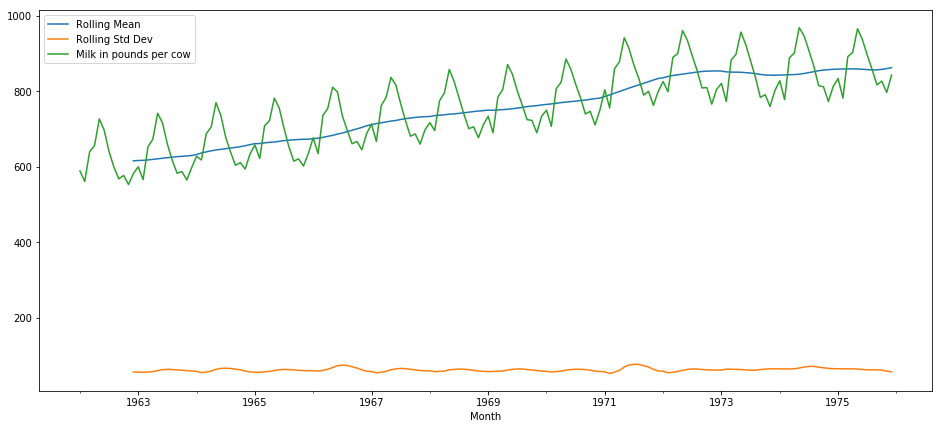

In [277]:
df['Milk in pounds per cow'].rolling(12).mean().plot(figsize = (16,7), label = 'Rolling Mean')
df['Milk in pounds per cow'].rolling(12).std().plot(label = 'Rolling Std Dev')
df['Milk in pounds per cow'].plot()
plt.legend()
plt.show()

### Decomposition

ETS Decomposition will help us figure out the individual parts.

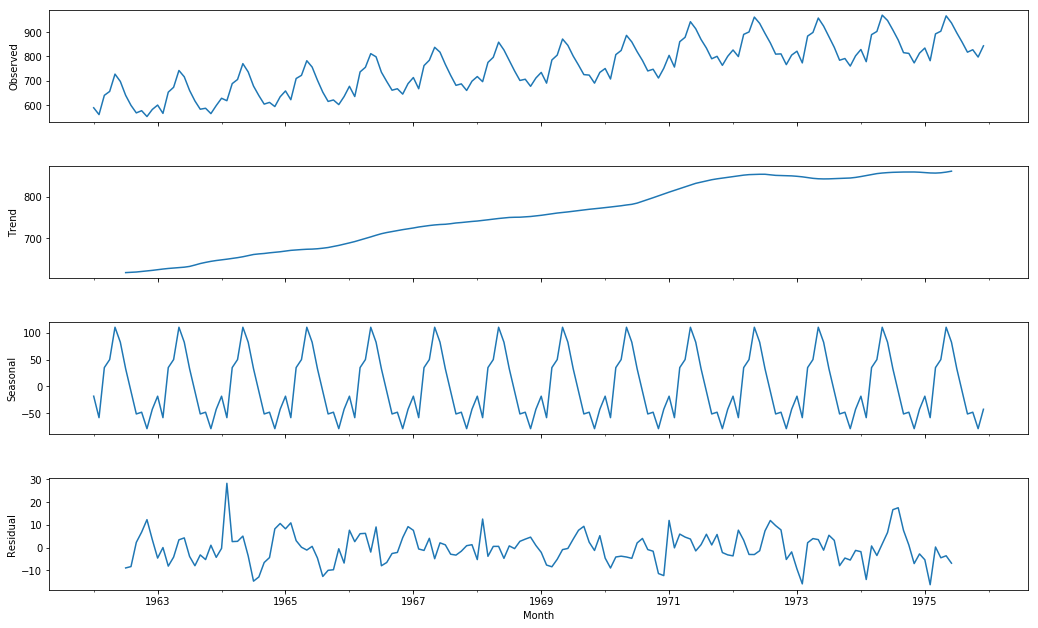

In [278]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Milk in pounds per cow'])
fig = decomposition.plot()
fig.set_size_inches(16,10)

### Testing for Stationarity

We can use the Augmented [Dickey-Fuller](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) [unit root test](https://en.wikipedia.org/wiki/Unit_root_test).

In statistics and econometrics, an augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.

Basically, we have to figure out whether to accept the Null Hypothesis **H0** (that the time series has a unit root, indicating it is non-stationary) or reject **H0** and go with the Alternative Hypothesis (that the time series has no unit root and is stationary).

We end up deciding this based on the p-value return.

* A small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so you reject the null hypothesis.

* A large p-value (> 0.05) indicates weak evidence against the null hypothesis, so you fail to reject the null hypothesis.


We can implement the Dickey Fuller test using the statsmodel's **adfuller()**

In [279]:
from statsmodels.tsa.stattools import adfuller

In [280]:
result = adfuller(df['Milk in pounds per cow'])

In [281]:
labels = ['ADF Test Statistic','p values','#Lags used','Number of Observations used']

for value, label in zip(result, labels):
    print(label + ' : ' + str(value)+ '\n')
    
if result[1] <= 0.05:
    print('Since the evidence is strog enough we reject the null hypothesis')
else:
    print('Since the evidence is not enough we fail to reject the null hypothesis')

ADF Test Statistic : -1.3038115874221228

p values : 0.6274267086030347

#Lags used : 13

Number of Observations used : 154

Since the evidence is not enough we fail to reject the null hypothesis


We better shape it as a function for multiple uses.

In [282]:
def adf_check(time_series):
    print('\n------Dickey Fuller Test Results---------\n')
    result = adfuller(time_series)
    labels = ['ADF Test Statistic','p values','#Lags used','Number of Observations used']

    for value, label in zip(result, labels):
        print(label + ' : ' + str(value)+'\n')
    
    if result[1] <= 0.05:
        print('Since the evidence is strog enough we reject the null hypothesis so time series is stationary')
    else:
        print('Since the evidence is not enough we fail to reject the null hypothesis, so time series is not stationary')
    

In [283]:
adf_check(df['Milk in pounds per cow'])


------Dickey Fuller Test Results---------

ADF Test Statistic : -1.3038115874221228

p values : 0.6274267086030347

#Lags used : 13

Number of Observations used : 154

Since the evidence is not enough we fail to reject the null hypothesis, so time series is not stationary


-----------

Since our data is seasonal as we can observe from our plot, we need to use the Seasonal ARIMA for our model otherwise we could have used ARIMA model.

### Differencing

The first difference of a time series is the series of changes from one period to the next. We can do this easily with pandas. You can continue to take the second difference, third difference, and so on until your data is stationary.

#### First Difference

In [284]:
df['First Difference'] = df['Milk in pounds per cow'] - df['Milk in pounds per cow'].shift(1)

In [285]:
adf_check(df['First Difference'].dropna())


------Dickey Fuller Test Results---------

ADF Test Statistic : -3.054995558653051

p values : 0.03006800400178724

#Lags used : 14

Number of Observations used : 152

Since the evidence is strog enough we reject the null hypothesis so time series is stationary


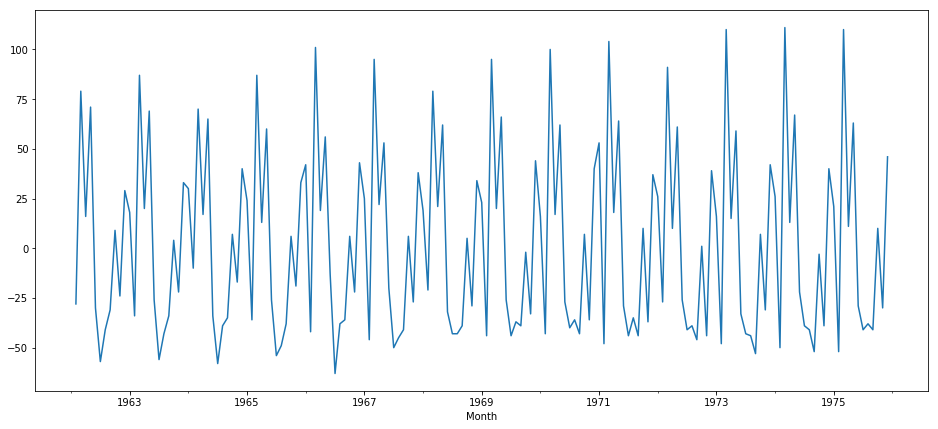

In [286]:
df['First Difference'].plot(figsize = (16,7));

#### Second Difference

Although we don't need the second difference for this data we just explore it.

In [287]:
df['Second Difference'] = df['First Difference'] - df['First Difference'].shift(1)

In [288]:
adf_check(df['Second Difference'].dropna())


------Dickey Fuller Test Results---------

ADF Test Statistic : -14.327873645603349

p values : 1.1126989332082667e-26

#Lags used : 11

Number of Observations used : 154

Since the evidence is strog enough we reject the null hypothesis so time series is stationary


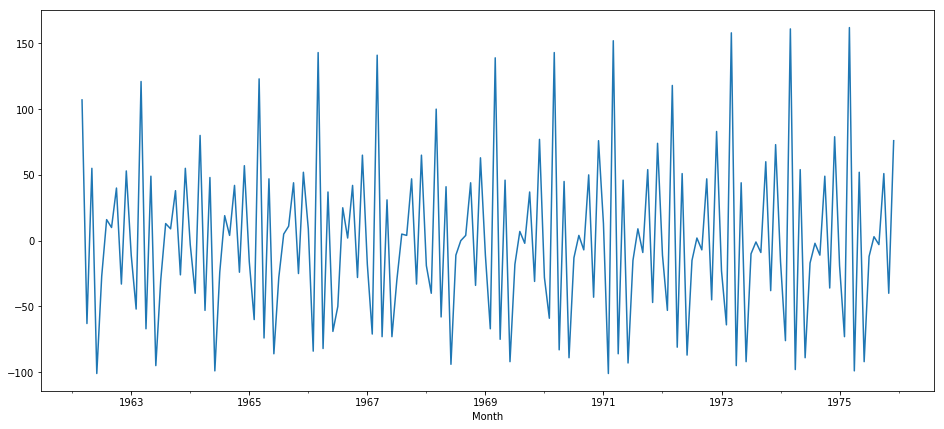

In [289]:
df['Second Difference'].plot(figsize = (16,7));

#### Seasonal Difference

In [290]:
df['Seasonal Difference'] = df['Milk in pounds per cow'] - df['Milk in pounds per cow'].shift(12)

In [291]:
adf_check(df['Seasonal Difference'].dropna())


------Dickey Fuller Test Results---------

ADF Test Statistic : -2.3354193143593993

p values : 0.16079880527711304

#Lags used : 12

Number of Observations used : 143

Since the evidence is not enough we fail to reject the null hypothesis, so time series is not stationary


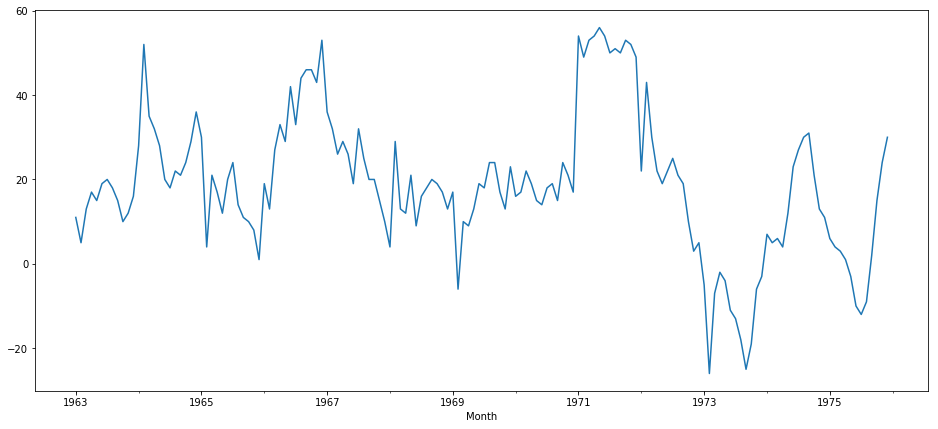

In [292]:
df['Seasonal Difference'].plot(figsize = (16,7));

### Seasonal First Difference

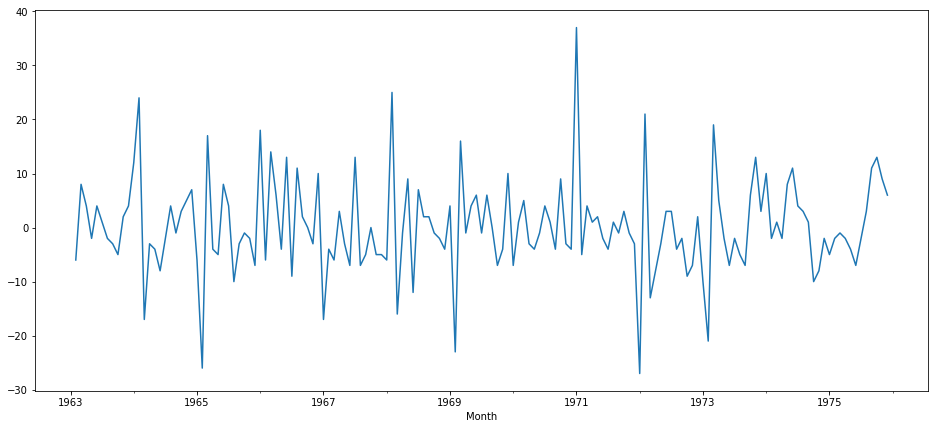

In [293]:
df['Seasonal First Difference'] = df['First Difference'] - df['First Difference'].shift(12)
df['Seasonal First Difference'].plot(figsize = (16,7));

In [294]:
adf_check(df['Seasonal First Difference'].dropna())


------Dickey Fuller Test Results---------

ADF Test Statistic : -5.038002274921985

p values : 1.86542343187882e-05

#Lags used : 11

Number of Observations used : 143

Since the evidence is strog enough we reject the null hypothesis so time series is stationary


## Autocorrelation and Partial Autocorrelation Plots

An autocorrelation plot (also known as a [Correlogram](https://en.wikipedia.org/wiki/Correlogram) ) shows the correlation of the series with itself, lagged by x time units. So the y axis is the correlation and the x axis is the number of time units of lag.

So imagine taking your time series of length T, copying it, and deleting the first observation of copy #1 and the last observation of copy #2. Now you have two series of length T−1 for which you calculate a correlation coefficient. This is the value of of the vertical axis at x=1x=1 in your plots. It represents the correlation of the series lagged by one time unit.

We will run these plots on your differenced/stationary data. Further information for identifying and interpreting ACF and PACF are [here](http://people.duke.edu/~rnau/arimrule.htm) and [here](https://people.duke.edu/~rnau/411arim3.htm).

### Autocorrelation Interpretation

The actual interpretation and how it relates to ARIMA models can get a bit complicated, but there are some basic common methods we can use for the ARIMA model. Our main priority here is to try to figure out whether we will use the AR or MA components for the ARIMA model (or both!) as well as how many lags we should use. In general you would use either AR or MA, using both is less common.

* If the autocorrelation plot shows positive autocorrelation at the first lag (lag-1), then it suggests to use the AR terms in relation to the lag

* If the autocorrelation plot shows negative autocorrelation at the first lag, then it suggests using MA terms.

#### Note
Here we will be running the ACF and PACF on multiple differenced data sets that have been made stationary in different ways, typically we would just choose a single stationary data set and continue all the way through with that.
The purpose of using two here is to explore the two typical types of behaviour we would see when using ACF.


In [295]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

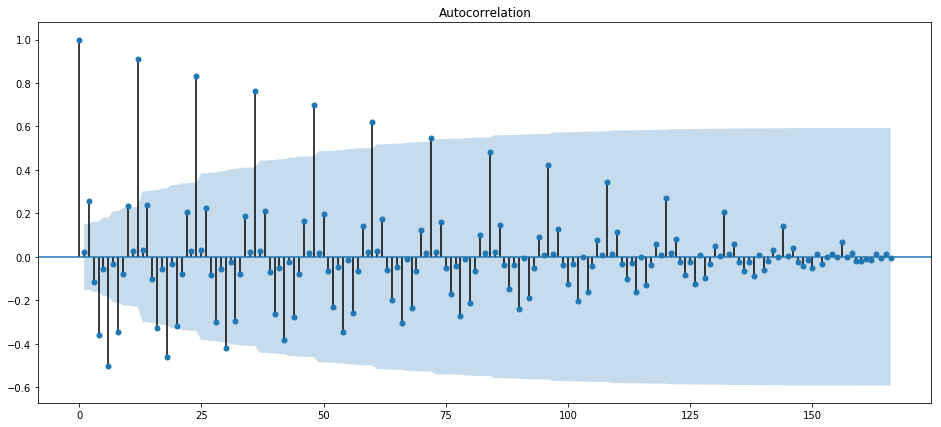

In [296]:
fig = plot_acf(df['First Difference'].dropna())
fig.set_size_inches(16,7);

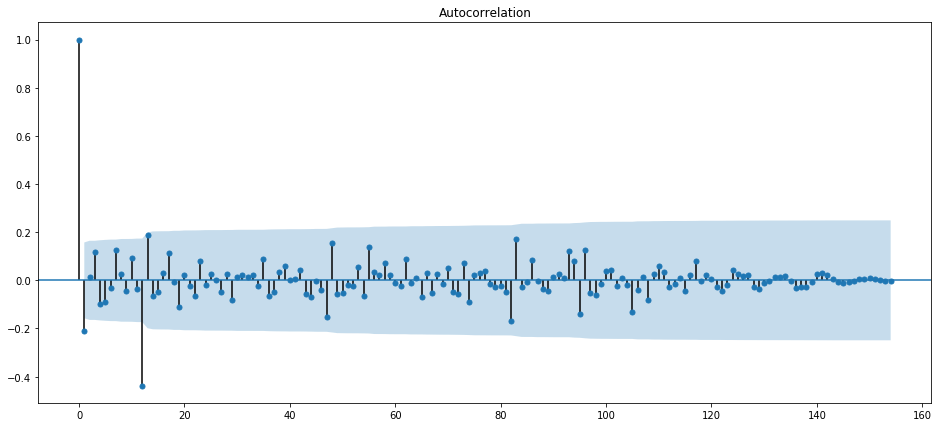

In [297]:
fig = plot_acf(df['Seasonal First Difference'].dropna())
fig.set_size_inches(16,7)

Pandas also has the functionality of Autocorrelation plots but statsmodel usage is more recommended as it it contains both.


In [298]:
from pandas.plotting import autocorrelation_plot

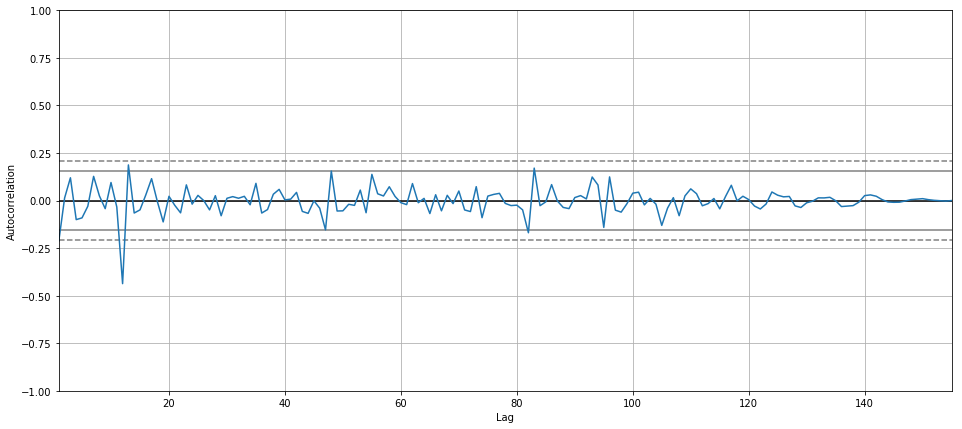

In [299]:
plt.figure(figsize= (16,7))
fig = autocorrelation_plot(df['Seasonal First Difference'].dropna())

## Partial Autocorrelation

In general, a partial correlation is a conditional correlation.

It is the correlation between two variables under the assumption that we know and take into account the values of some other set of variables.

For instance, consider a regression context in which y = response variable and x1, x2, and x3 are predictor variables.  The partial correlation between y and x3 is the correlation between the variables determined taking into account how both y and x3 are related to x1 and x2.

Formally, this is relationship is defined as:

## $\frac{\text{Covariance}(y, x_3|x_1, x_2)}{\sqrt{\text{Variance}(y|x_1, x_2)\text{Variance}(x_3| x_1, x_2)}}$

More details [here](http://www.itl.nist.gov/div898/handbook/pmc/section4/pmc4463.htm).

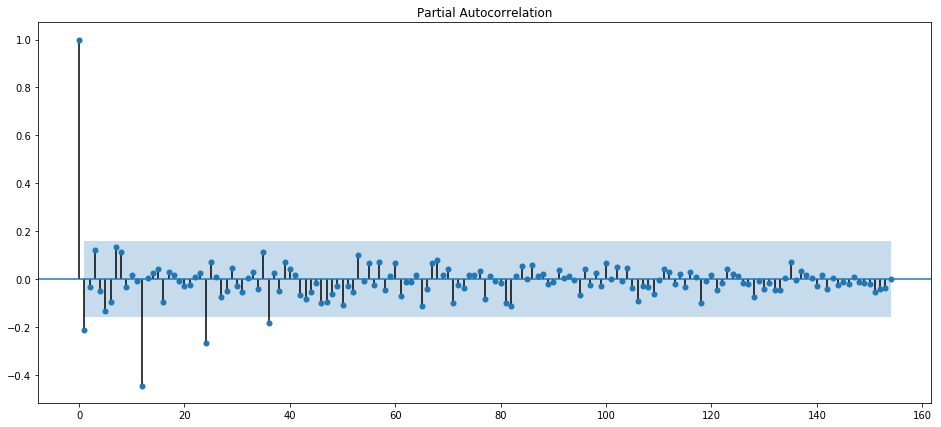

In [300]:
fig = plot_pacf(df['Seasonal First Difference'].dropna())
fig.set_size_inches(16,7)

### Interpretation

Typically a sharp drop after lag "k" suggests an AR-k model should be used. If there is a gradual decline, it suggests an MA model.

### Final Thoughts on Autocorrelation and Partial Autocorrelation

* Identification of an AR model is often best done with the PACF.
    * For an AR model, the theoretical PACF “shuts off” past the order of the model.  The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point.  Put another way, the number of non-zero partial autocorrelations gives the order of the AR model.  By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
    
    
* Identification of an MA model is often best done with the ACF rather than the PACF.
    * For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner.  A clearer pattern for an MA model is in the ACF.  The ACF will have non-zero autocorrelations only at lags involved in the model.

___
Now getting our "final" ACF and PACF plots. These are the ones we will be referencing further here.


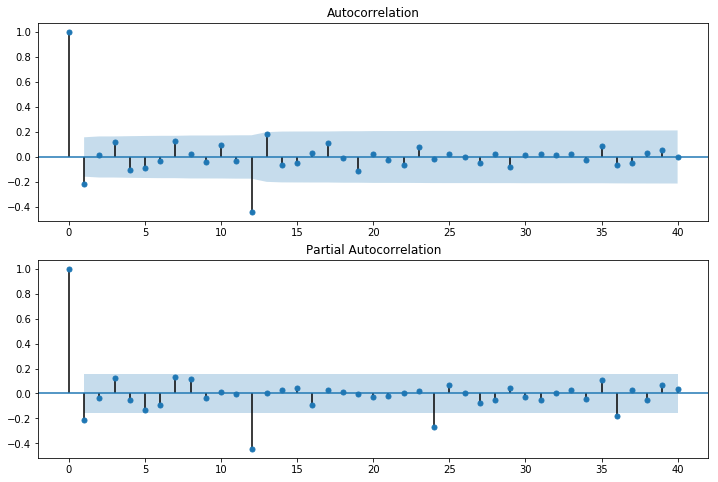

In [301]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].dropna(), lags=40, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].dropna(), lags=40, ax= ax2)


## Using the Seasonal ARIMA Model

In [302]:
from statsmodels.tsa.arima_model import ARIMA

In [303]:
help(ARIMA)

Help on class ARIMA in module statsmodels.tsa.arima_model:

class ARIMA(ARMA)
 |  Autoregressive Integrated Moving Average ARIMA(p,d,q) Model
 |  
 |  Parameters
 |  ----------
 |  endog : array-like
 |      The endogenous variable.
 |  order : iterable
 |      The (p,d,q) order of the model for the number of AR parameters,
 |      differences, and MA parameters to use.
 |  exog : array-like, optional
 |      An optional array of exogenous variables. This should *not* include a
 |      constant or trend. You can specify this in the `fit` method.
 |  dates : array-like of datetime, optional
 |      An array-like object of datetime objects. If a pandas object is given
 |      for endog or exog, it is assumed to have a DateIndex.
 |  freq : str, optional
 |      The frequency of the time-series. A Pandas offset or 'B', 'D', 'W',
 |      'M', 'A', or 'Q'. This is optional if dates are given.
 |  
 |  
 |  Notes
 |  -----
 |  If exogenous variables are given, then the model that is fit is
 

### p,d,q parameters

* p: The number of lag observations included in the model.
* d: The number of times that the raw observations are differenced, also called the degree of differencing.
* q: The size of the moving average window, also called the order of moving average.

In [304]:
#We have seasonal data
model = sm.tsa.statespace.SARIMAX(df['Milk in pounds per cow'], order = (0, 1, 0), seasonal_order= (1, 1, 1, 12))
                  #Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors
results = model.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:             Milk in pounds per cow   No. Observations:                  168
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -534.065
Date:                            Fri, 11 Jan 2019   AIC                           1074.131
Time:                                    15:24:49   BIC                           1083.503
Sample:                                01-01-1962   HQIC                          1077.934
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0449      0.106     -0.422      0.673      -0.253       0.163
ma.S.L12      -0.5860      0.102   

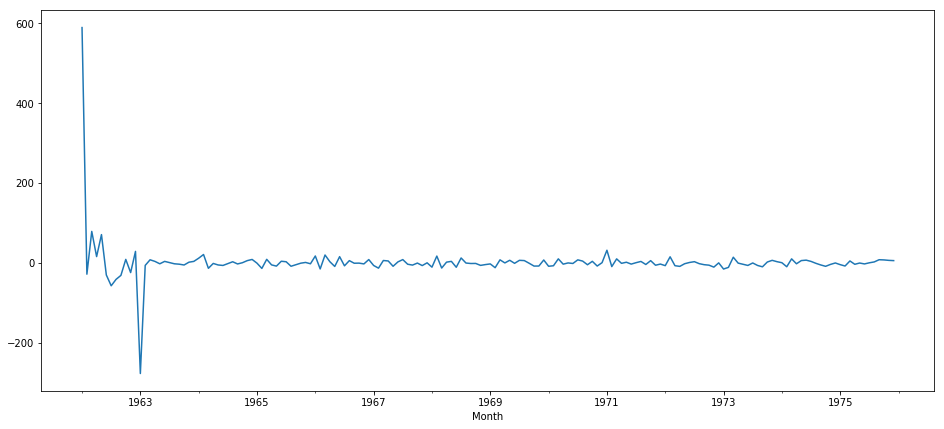

In [305]:
results.resid.plot(figsize = (16,7));

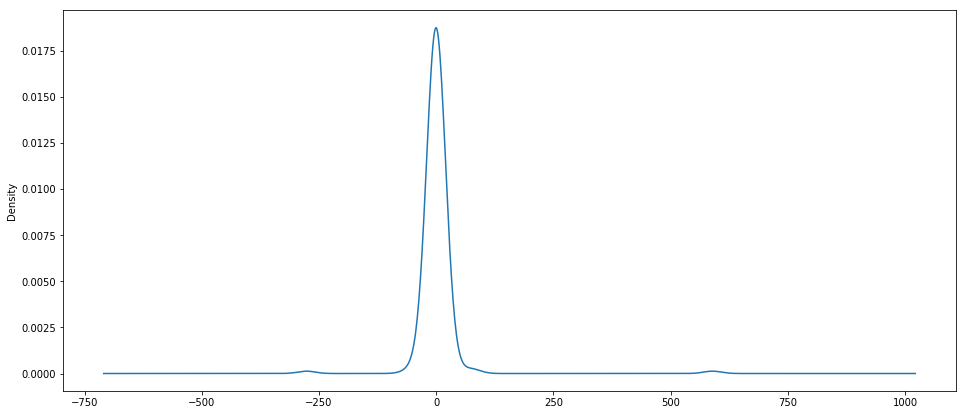

In [306]:
results.resid.plot(kind = 'kde',figsize = (16,7));

## Prediction of Future Values

First we can get an idea of how well our model performs by just predicting for values that we actually already know:

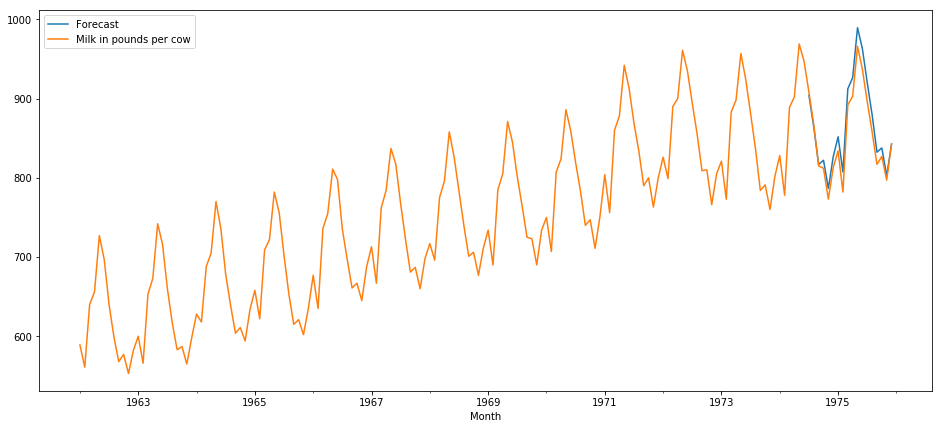

In [307]:
df['Forecast'] = results.predict(start = 150, end = 168, dynamic = True)
df[['Forecast','Milk in pounds per cow']].plot(figsize = (16,7));

For further forecast we will require more datapoints so we need to create more.

In [308]:
df.tail()

,Milk in pounds per cow,First Difference,Second Difference,Seasonal Difference,Seasonal First Difference,Forecast
Month,,,,,,
1975-08-01,858.0,-38.0,3.0,-9.0,3.0,879.668789
1975-09-01,817.0,-41.0,-3.0,2.0,11.0,832.328246
1975-10-01,827.0,10.0,51.0,15.0,13.0,837.721945
1975-11-01,797.0,-30.0,-40.0,24.0,9.0,802.452363
1975-12-01,843.0,46.0,76.0,30.0,6.0,842.499524


In [309]:
from pandas.tseries.offsets import DateOffset

In [310]:
future_dates = [df.index[-1] + DateOffset(months = x) for x in range(1, 25)]

In [311]:
future_dates_df = pd.DataFrame(index= future_dates, columns= df.columns)

In [312]:
future_df = pd.concat([df, future_dates_df])
future_df.tail()

,Milk in pounds per cow,First Difference,Second Difference,Seasonal Difference,Seasonal First Difference,Forecast
1977-08-01,NaN,NaN,NaN,NaN,NaN,NaN
1977-09-01,NaN,NaN,NaN,NaN,NaN,NaN
1977-10-01,NaN,NaN,NaN,NaN,NaN,NaN
1977-11-01,NaN,NaN,NaN,NaN,NaN,NaN
1977-12-01,NaN,NaN,NaN,NaN,NaN,NaN


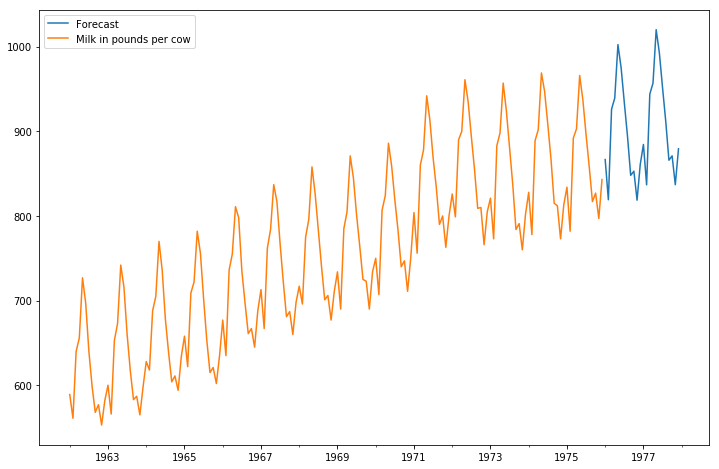

In [313]:
future_df['Forecast'] = results.predict(start= 168, end = 191, dynamic = True)
future_df[['Forecast','Milk in pounds per cow']].plot(figsize = (12,8));

There are several caveats to the ARIMA model and therefore it is not the most practical model but still is a good way of understandig the financial analysis.

### de nada!